# Creating and Tuning Models

## Importing libraries

In [1]:
import csv
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
import pandas as pd
from matplotlib import pyplot as plt

## Reading in CSV data
Reading the dataset from a CSV into a DataFrame for use with the model.
Remove unnecessary data and split into data and labels.

In [2]:
music_df = pd.read_csv("extracted-features.csv")

## This will contain the data
data = music_df.iloc[:, 1:].values
## This will contain the labels corresponding to the data
labels = music_df.iloc[:, 0].values

## Split the data into training and testing sets
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size = 0.30)

# Combine testing labels and data and store as a CSV to be used later
testing_data = []
for i in range(0, len(labels_test), 1):
    testing_data.append([labels_test[i], data_test[i][0], data_test[i][1], data_test[i][2], data_test[i][3]])

# print(testing_data)

with open("testing_data.csv", mode = 'w', newline = '') as test_data_file:
    test_data_writer = csv.writer(test_data_file, delimiter = ',')
    test_data_writer.writerow(["Genre", "MFCC", "ZCR", "Spectral Centroid", "Spectral Rolloff"])

    for i in range(0, len(testing_data), 1):
        test_data_writer.writerow(testing_data[i])

## Cross-validate KNN to find the best hyper-parameters

Use GridSearchCV to evaluate the optimal hyperparameters for the algorithm.

{'metric': 'manhattan', 'n_neighbors': 24, 'weights': 'distance'}
              precision    recall  f1-score   support

       Blues       0.24      0.33      0.28        24
   Classical       0.64      0.58      0.61        31
     Country       0.21      0.21      0.21        34
       Disco       0.17      0.21      0.19        28
      HipHop       0.27      0.19      0.23        31
        Jazz       0.23      0.30      0.26        23
       Metal       0.51      0.66      0.58        32
         Pop       0.48      0.42      0.45        26
      Reggae       0.38      0.27      0.32        37
        Rock       0.15      0.12      0.13        34

    accuracy                           0.33       300
   macro avg       0.33      0.33      0.32       300
weighted avg       0.33      0.33      0.32       300

ROC AUC: 0.724641445685088


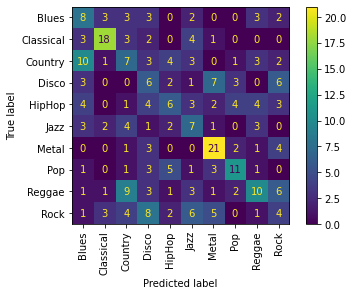

In [3]:
knn_model = KNeighborsClassifier()

param_grid = {"n_neighbors": range(1, 25),
              "weights": ["uniform", "distance"],
              "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]}

scoring_metrics = {"Accuracy": "accuracy",
                   "AUC": "roc_auc_ovr",
                   "F1": "f1_macro"}

## roc_auc_ovr sets the score to use roc_auc in one vs rest mode
## StratifiedKFold is used by default for the cross validation
knn_grid_search_cv = GridSearchCV(knn_model,
                                  param_grid,
                                  scoring = scoring_metrics,
                                  refit = "AUC",
                                  cv = 5)

knn_grid_search_cv.fit(data_train, labels_train)

best_params = knn_grid_search_cv.best_params_

print(best_params)

knn_grid_predict = knn_grid_search_cv.predict(data_test)

print(classification_report(labels_test, knn_grid_predict))

plot_confusion_matrix(estimator=knn_grid_search_cv, X=data_test, y_true=labels_test, xticks_rotation="vertical")
plt.show()

## Best score is using the metric defined in refit
print("ROC AUC: " + str(knn_grid_search_cv.best_score_))

best_k_value = best_params["n_neighbors"]
best_weighting = best_params["weights"]
best_distance_metric = best_params["metric"]

## Cross-validate SVM to find the best hyper-parameters

Use GridSearchCV to evaluate the optimal hyperparameters for the algorithm.

{'C': 1000, 'gamma': 'scale'}
              precision    recall  f1-score   support

       Blues       0.16      0.21      0.18        24
   Classical       0.74      0.90      0.81        31
     Country       0.14      0.03      0.05        34
       Disco       0.21      0.21      0.21        28
      HipHop       0.32      0.26      0.29        31
        Jazz       0.16      0.39      0.22        23
       Metal       0.57      0.62      0.60        32
         Pop       0.53      0.62      0.57        26
      Reggae       0.25      0.16      0.20        37
        Rock       0.17      0.12      0.14        34

    accuracy                           0.34       300
   macro avg       0.33      0.35      0.33       300
weighted avg       0.33      0.34      0.32       300

ROC AUC: 0.7795285473759657


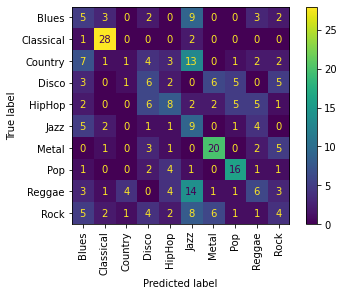

In [4]:
svm_model = SVC(probability = True, kernel = "rbf")

param_grid = {"C": [0.1, 1, 10, 100, 1000],
              "gamma": ["scale", "auto"]}

scoring_metrics = {"Accuracy": "accuracy",
                   "AUC": "roc_auc_ovr",
                   "F1": "f1_macro"}

## roc_auc_ovr sets the score to use roc_auc in one vs rest mode
## StratifiedKFold is used by default for the cross validation
svm_grid_search_cv = GridSearchCV(svm_model,
                                  param_grid,
                                  scoring = scoring_metrics,
                                  refit = "AUC",
                                  cv = 5)

svm_grid_search_cv.fit(data_train, labels_train)

best_params = svm_grid_search_cv.best_params_

print(best_params)

svm_grid_predict = svm_grid_search_cv.predict(data_test)

print(classification_report(labels_test, svm_grid_predict))

plot_confusion_matrix(estimator=svm_grid_search_cv, X=data_test, y_true=labels_test, xticks_rotation="vertical")
plt.show()

## Best score is using the metric defined in refit
print("ROC AUC: " + str(svm_grid_search_cv.best_score_))

best_c_value = best_params["C"]
best_gamma = best_params["gamma"]

## Save models

Save the tuned KNN and SVM models using the optimal hyperparameters and save to a Pickle file for use with Azure.

In [5]:
with open("models/knn.pkl", mode = "wb") as model_file:
    pickle.dump(knn_grid_search_cv, model_file)

with open("models/svm.pkl", mode = "wb") as model_file:
    pickle.dump(svm_grid_search_cv, model_file)